<center><h1>NLP project</h1></center>

<center>
  <h2>Table of contents:</h2>
    <h3>1. Project Overview</h3>
    <h3>2. Data Overview</h3>
    <h3>3. Exploratory Data Analysis</h3>
    <h3>4. Topic Modelling of Questions</h3>
    <h3>5. Sentiment Analysis of Answers</h3>
    <h3>6. ML Classification</h3>
    <h3>7. Summary</h3>
</center>

### Project Overview
The goal of this project is to use various Natural Language Processing (NLP) methods to analyze frequently asked questions and their corresponding answers on many SaaS companies pricing pages. We want to understand what are the most frequent words, and questions schemas, and whether it is possible or not to predict the pricing model the company uses based on the questions it has on its pricing page. 

### Data Overview
The data used for this project was scraped from the urls in ai_pricing_index.csv. The dataset was acquired from `https://pricingsaas.com/pricingIndex/` page. Then i used firecrawl scraper to gather data such as company name, their industry, the pricing model and questions and answers from the pricing page. The code used to scrape is in `scraper.py`, and the scraped data in `final_data.json`. Final data consists of `69` unique companies and `632` unique question and answers. All companies which are on the pricing Index are using in some way AI in their product, but only in some cases the AI is main feture of the product.

In [ ]:
# for data manipulation panadas is used
# for plotting I used matplotlib and seaborn
# machine learning models are implemented using sklearn and xgboost
# NLP is implemented using nltk and transformers

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import json
import re
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from transformers import BertTokenizer, BertForSequenceClassification
import torch

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
with open('data/final_data.json', 'r') as file:
    data = json.load(file)

In [4]:
all_faqs = []

for entry in data:
    if 'data' in entry and entry['data'] is not None:
        faqs = entry['data'].get('frequently_asked_questions')
        faq_answers = entry['data'].get('frequently_asked_questions_answers')
        
        if faqs is not None and faq_answers is not None and isinstance(faqs, list) and isinstance(faq_answers, list):
            company = entry.get('company')
            ai_pricing_model = entry.get('ai_pricing_model')
            category = entry.get('category')
            
            for question, answer in zip(faqs, faq_answers):
                all_faqs.append({
                    'question': question,
                    'answer': answer,
                    'company': company,
                    'ai_pricing_model': ai_pricing_model,
                    'category': category
                })
data = pd.DataFrame(all_faqs)

### Data Exploration

The data consists of 5 fields: 
- company: the name of the company
- category: the industry the company is in
- ai_pricing_model: the type of pricing model the company uses (Tiered, Usage, Addon)
- questions: frequently asked questions from pricing pages
- answers: answers to the above mentioned questions

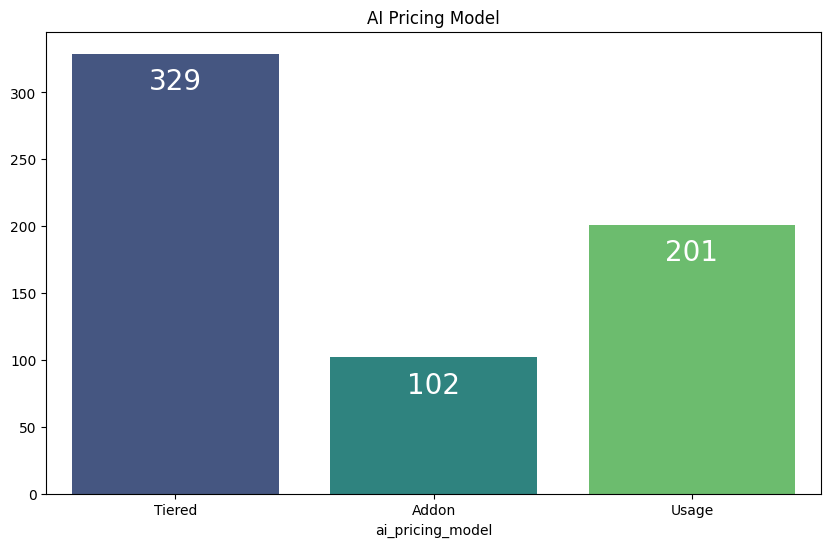

In [5]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['ai_pricing_model'], palette='viridis')
plt.ylabel('')
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, -20),
        textcoords='offset points',
        color="white",
        fontsize=20,
    )

plt.title('AI Pricing Model')
plt.show()

We see that the data is inbalanced, the majority of `ai_pricing_model` is `Tiered` pricing, then we have `Usage` and lastly `Addon` 

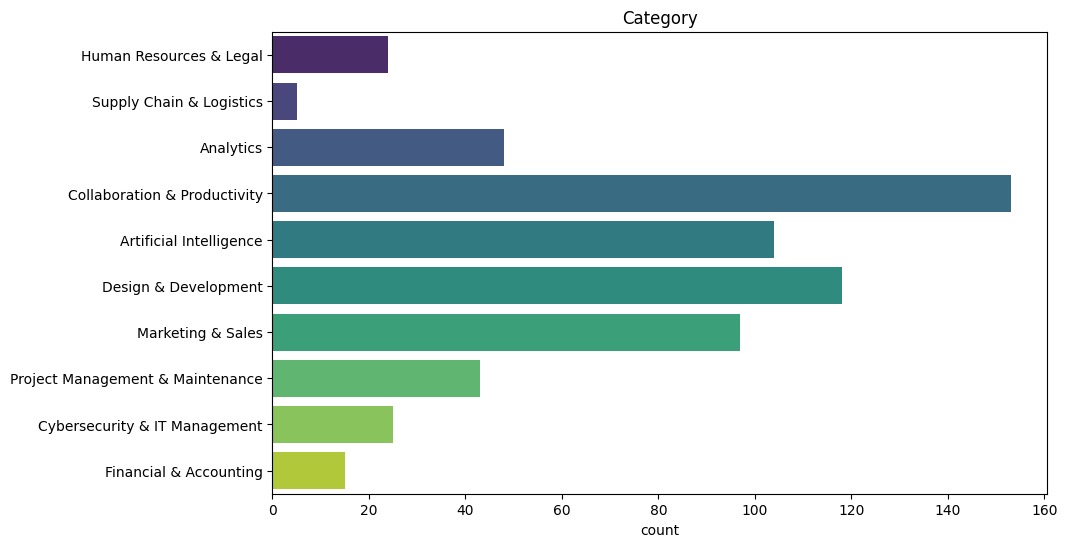

In [6]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y=data['category'], palette='viridis')
plt.ylabel('')
plt.title('Category')
plt.show()

We see the biggest group of companies using AI in their products are in `Collaboration & Productivity` and `Design`. The reason for this may be because those fields are not very risk heavy in comparison to ex. `Financial & Accounting` or `Supply Chain & Logistics` which require high precision, not yet achived by AI.

In [7]:
# average questions per company
data.groupby('company').size().mean()

9.159420289855072

The average of the questions on each pricing page is around 9, but we expect many questions relate to similar topics. We can expect questions about the features of the product, the costs and probably free tier.

### Text cleaning

In [8]:
def remove_emojis_and_non_ascii(text):
    if text is None:
        return text
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[/|\\(){}[\],;:—\-]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [10]:
stop_words = set(stopwords.words('english'))
stop_words.update(data["company"].str.lower().unique()) # the company name wont bring any added value
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [11]:
stemmer = PorterStemmer()
def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

In [12]:
# Remove emojis and non-ascii characters
data['question'] = data['question'].apply(remove_emojis_and_non_ascii).apply(clean_text)
data['answer'] = data['answer'].apply(remove_emojis_and_non_ascii).apply(clean_text)

# Tokenize the text
data['question_tokens'] = data['question'].apply(word_tokenize)
data['answer_tokens'] = data['answer'].apply(word_tokenize)

# Remove stopwords
data['question_tokens'] = data['question_tokens'].apply(remove_stopwords)
data['answer_tokens'] = data['answer_tokens'].apply(remove_stopwords)

# Stem the tokens
data['question_tokens'] = data['question_tokens'].apply(stem_text)
data['answer_tokens'] = data['answer_tokens'].apply(stem_text)

### Vectorization

In [13]:
data['question_text'] = data['question_tokens'].apply(lambda tokens: ' '.join(str(token) for token in tokens))
data['answer_text'] = data['answer_tokens'].apply(lambda tokens: ' '.join(str(token) for token in tokens))

vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
question_counts = vectorizer.fit_transform(data['question_text'])
answer_counts = vectorizer.transform(data['answer_text'])

tfidata_transformer = TfidfTransformer()
question_tfidata = tfidata_transformer.fit_transform(question_counts)
answer_tfidata = tfidata_transformer.transform(answer_counts)

question_tfidata_data = pd.DataFrame(question_tfidata.toarray(), columns=vectorizer.get_feature_names_out())
answer_tfidata_data = pd.DataFrame(answer_tfidata.toarray(), columns=vectorizer.get_feature_names_out())

data = pd.concat([data, question_tfidata_data.add_prefix('question_tfidf_'), answer_tfidata_data.add_prefix('answer_tfidf_')], axis=1)

### Exploration of Questions

there are on average around 9 questions per pricing page. Probably most will concern similar topics, but let's check if the topics can be distinguished using `LatentDirichletAllocation`

In [14]:
def generate_wordcloud(tfidf_data):
    tfidf_dict = dict(zip(tfidf_data.columns, tfidf_data.sum()))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [15]:
# Top words for questions
question_top_words = question_tfidata_data.sum().sort_values(ascending=False).head(10)
print("Top words in questions:")
print(question_top_words)

Top words in questions:
plan        30.641126
free        24.616600
trial       23.171068
offer       19.598156
work        17.955406
price       17.113229
discount    16.559051
payment     15.366794
bill        14.634420
use         13.459703
dtype: float64


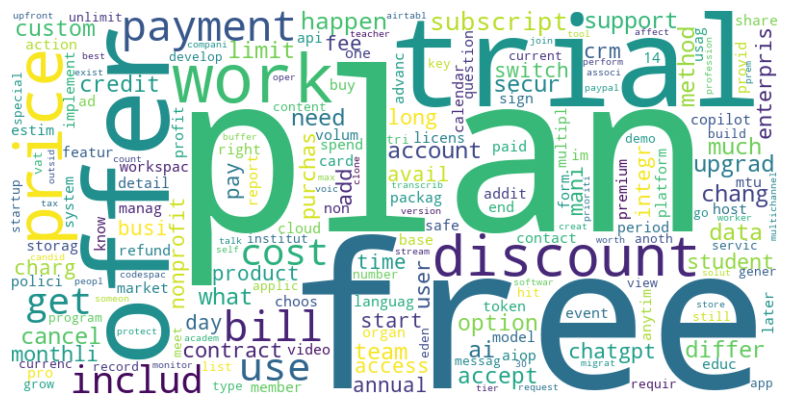

In [16]:
generate_wordcloud(question_tfidata_data)

- questions indicate that customers are highly concerned and interested in understanding the detail of different pricing plans, including features, limitations and costs
- free tiers and plans are a major focus. Customers usually ask what the free tier offer, and how long does it last
- billing and payment-related questions are common, but also the questions about discounts and special offers are frequently asked
- interestingly the questions about features and how the product work are rarely present in those FAQs

### Topic modelling in Questions

In [17]:
n_topics = 9
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

lda.fit(question_counts)

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names)

Topic 1:
payment bill method accept annual monthli use charg account share
Topic 2:
support upgrad account busi use team need manag copilot chang
Topic 3:
data ai get credit access secur use chatgpt need card
Topic 4:
price much cost custom work offer crm includ cloud integr
Topic 5:
plan subscript cancel differ team includ chang avail pro switch
Topic 6:
free trial plan happen get start limit enterpris option end
Topic 7:
discount offer student nonprofit question startup volum educ organ happen
Topic 8:
work trial user bill day period long workspac contract refund
Topic 9:
spend ai add upgrad ad plan pay later limit im


Reading the most common words within a topc we can distinguish few similar groups:
- Pricing and Billing (topic 1,4,5,8): where questions are about pricing plans, billing methods, subscriptions and refunds
- Features and Usage (topic 2,3,9): where questions are about product features, AI capabilities, and account usage
- Trials and Discounts (topic 6,7): where questions concern free trials and their limitations as well as available discounts

### Exploration of Answers

In [18]:
# Top words for answers
answer_top_words = answer_tfidata_data.sum().sort_values(ascending=False).head(10)
print("Top words in answers:")
print(answer_top_words)

Top words in answers:
plan         43.816222
team         25.939692
account      24.845762
user         21.567562
free         21.339709
bill         19.342716
use          18.425474
credit       18.289702
featur       18.168604
enterpris    17.706705
dtype: float64


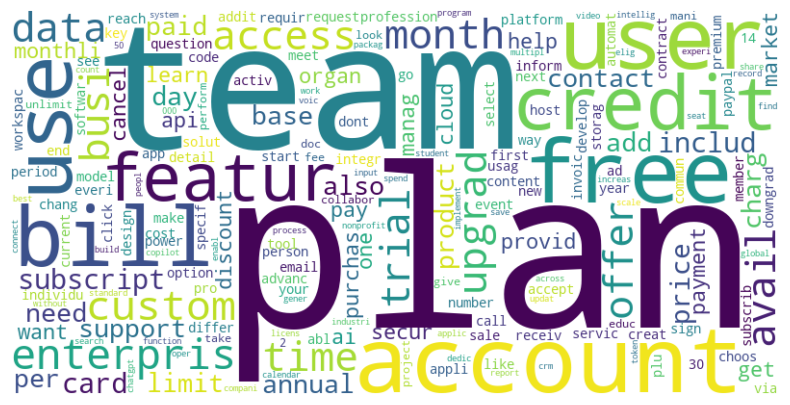

In [19]:
generate_wordcloud(answer_tfidata_data)

We see that the words commonly used in answers are similar to the once used in questions. It was expected as in order to clearly explain the topic, companies try to use same language the question was asked in.

### Sentiment analysis of Answers

I implement two approaches for analyzing the sentiment of the answers, one is Lexicon based (VADER) and the other transformer based (BERT). `VADER` (Valence Aware Dictionary and sEntiment Reasoner) is a dictionary rule-based sentiment analysis tool specifically designed for analyzing sentiments in media text, though it works well for general text too.

In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
def vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

data['vader_sentiment'] = data['answer_text'].apply(vader_sentiment)
data['vader_compound_score'] = data['vader_sentiment'].apply(lambda x: x['compound'])
data['vader_sentiment_label'] = data['vader_compound_score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

In [22]:
data[['answer_text', 'vader_compound_score', 'vader_sentiment_label']].head()

,answer_text,vader_compound_score,vader_sentiment_label
0,free trial give access full version profession...,0.8074,positive
1,offer three us base support plan tier suit wid...,0.9100,positive
2,purchas support plan custom profession servic ...,0.6597,positive
3,activconnect api set api connector tool enabl ...,0.0000,neutral
4,account paid plan extend total data histori in...,0.1779,positive


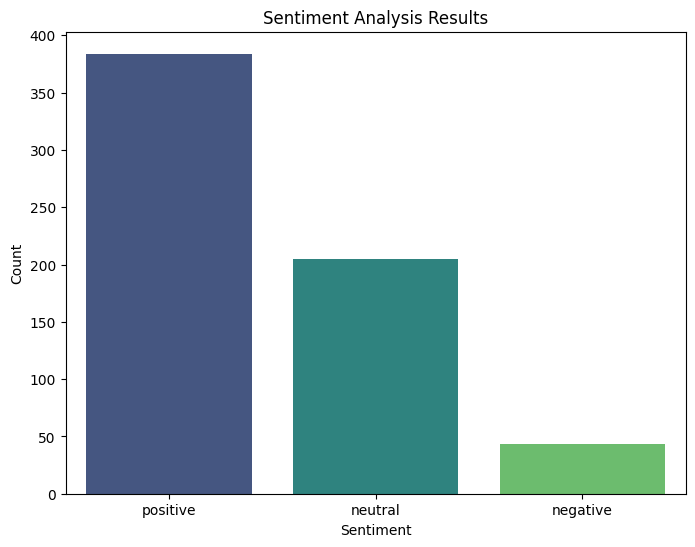

In [23]:
sentiment_counts = data['vader_sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()

We see the majority of answers are with positive sentiment, which was expected as companies should use kind, welcoming tone to answer product related questions. The negative answers may come from questions related to canceling the subscription, or support when some features don't work. Additionaly a big part of all answers is neutral. It was also quite expected as generally answers to pricing related questions don't seem particularly emotional/sentimental.

In [24]:
# top 1 positive answers
top_1_positive = data.nlargest(1, 'vader_compound_score')
print(top_1_positive['answer'].to_list())

['your trial includes free access to the databricks data intelligence platform which allows you to manage all your data analytics and ai in one place you may also invite colleagues or collaborators to use your account during or after your trial please note that if you configure databricks to work with your own cloud account you will still be charged by your cloud provider for resources like compute instances used within your account during the free trial some trials include credits that can be spent on databricks services these credits are not transferable cannot be combined with other promotions or negotiated terms and are not available to customers who previously accepted them a customers eligibility for credits under this offer the amount of credits if any and when any credits expire are solely determined by databricks following account creation a customers trial ends when their credits are exhausted']


In [25]:
# top 1 negative answers
top_1_negative = data.nsmallest(1, 'vader_compound_score')
print(top_1_negative['answer'].to_list())

['the screen details add on unlocks access to granular work activity data such as screenshots screen views title bars full urls and the ability to set alarms and block websites to purchase admins can add screen details to their paid plan within the activtrak app via email at salesactivtrakcom or use the chat icon below to connect with our team immediately']


As expected the actual sentences do not seem very sentimental as they are just marketing responses to frequently asked questions.

To compare the sentiment results of our answers `BERT` is used. BERT (Bidirectional Encoder Representations from Transformers) is a NLP model developed by Google in 2018. It is based on the Transformer architecture and is design to understand the context of words in a sentence by looking at both the left and right context (bidirectional). It achives quite high accuracy, but as it is a transformer model the factors that influence the final sentiment of a sentece can't be interpreted. 

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def preprocess(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
tokenized_data = data['answer_text'].apply(preprocess)

In [28]:
model.eval()

def predict_sentiment(text):
    inputs = preprocess(text)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    return probabilities[0].tolist()

data['sentiment_scores'] = data['answer_text'].apply(predict_sentiment)
data['positive_score'] = data['sentiment_scores'].apply(lambda x: x[1])
data['negative_score'] = data['sentiment_scores'].apply(lambda x: x[0])
data['sentiment_label'] = data['positive_score'].apply(lambda x: 'positive' if x >= 0.5 else 'negative')

In [29]:
data[['answer_text', 'positive_score', 'negative_score', 'sentiment_label']].head()

,answer_text,positive_score,negative_score,sentiment_label
0,free trial give access full version profession...,0.490271,0.509729,negative
1,offer three us base support plan tier suit wid...,0.510454,0.489546,positive
2,purchas support plan custom profession servic ...,0.500019,0.499981,positive
3,activconnect api set api connector tool enabl ...,0.518472,0.481528,positive
4,account paid plan extend total data histori in...,0.521020,0.478980,positive


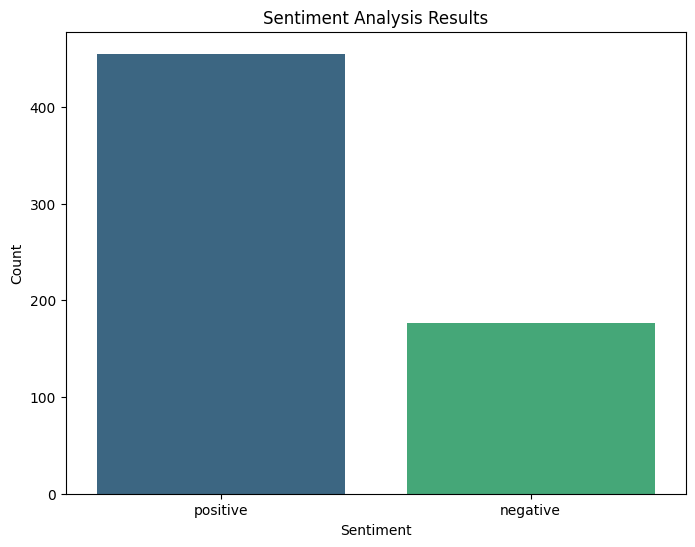

In [30]:
sentiment_counts = data['sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()

We see the majority of answers are with positive sentiment, which was expected as companies should use kind, welcoming tone to answer product related questions. The negative answers may come from questions related to canceling the subscription, or support when some features don't work. Let's inspect them:

In [31]:
# top 1 positive answers
top_1_positive = data.nlargest(1, 'positive_score')
print(top_1_positive['answer'].to_list())

['yes through openai for nonprofits eligible nonprofits can receive a 20 discount on subscriptions to chatgpt team and a 50 discount to chatgpt enterprise to apply for the chatgpt team discount click here to apply for a nonprofit discount on chatgpt enterprise please contact sales']


In [32]:
# top 1 negative answers
top_1_negative = data.nlargest(1, 'negative_score')
print(top_1_negative['answer'].to_list())

['our on prem plans have several implementations available on premises private cloud air gapped and managed service single tenant cloud']


We can clearly see that the top answers are not particularly emotional, they rather present facts and statements, thus the sentiment analysis does not bring high value. We have to remember that BERT is a complex model, it doesn't provide direct word-level contributions like simpler models, thus we can't preview how each word contributed to the final sentiment score.

### Classification model

Based on the collected data I have came up with the question, whether we can predict the pricing model based on the questions and industry (category) the company is in. I perform multiple models and try assesing the Accuracy of every to find the best performing one.

In [33]:
data["text"] = data["question_text"] + " " + data["answer_text"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['text', 'category']], 
    data['ai_pricing_model'], 
    test_size=0.2, random_state=42)

In [35]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
category_encoded_train = encoder.fit_transform(X_train[['category']])
category_encoded_test = encoder.transform(X_test[['category']])
category_encoded_train_df = pd.DataFrame(category_encoded_train, columns=encoder.get_feature_names_out(['category']))
category_encoded_test_df = pd.DataFrame(category_encoded_test, columns=encoder.get_feature_names_out(['category']))

In [36]:
vectorizer = TfidfVectorizer(max_features=5000)
text_vec_train = vectorizer.fit_transform(X_train['text'])
text_vec_test = vectorizer.transform(X_test['text'])

In [37]:
X_train_final = sp.hstack([text_vec_train, category_encoded_train_df])
X_test_final = sp.hstack([text_vec_test, category_encoded_test_df])

In [38]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

now:
- **`Addon` is 0**
- **`Tiered` is 1**
- **`Usage` is 2**

**Random Forest**

In [39]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_final, y_train_encoded)

y_pred_encoded  = rf_model.predict(X_test_final)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_encoded ))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred_encoded ))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_encoded ))

Accuracy: 0.6850393700787402
Balanced Accuracy: 0.5839371980676328
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.21      0.34        24
           1       0.59      1.00      0.74        57
           2       1.00      0.54      0.70        46

    accuracy                           0.69       127
   macro avg       0.86      0.58      0.60       127
weighted avg       0.81      0.69      0.65       127



The `random forest` classifier reulted in `Accuracy = 0.68` and `Balanced Accuracy = 0.57`, which is not a great result but indicates some pricing types can be predicted. The two other important metrics: Precision and Recall indicate that:
- only `12%` of actual `Addon` samples were correctly predicted, but 25% false positives
- `100%` `Tiered` samples were correctly predicted, but `60%` of all predictions for this class were True Positive
- `59%` of `Usage` samples were correctly predicted, and `96%` were true positives

As the dataset is inbalanced (Tiered is the most frequent class) the model is biased towards it.

**XGBoost**

In [40]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_final, y_train_encoded)

y_pred_encoded = xgb_model.predict(X_test_final)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_encoded))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred_encoded))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_encoded))

Accuracy: 0.7165354330708661
Balanced Accuracy: 0.6517289600813628
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.42      0.57        24
           1       0.64      0.93      0.76        57
           2       0.85      0.61      0.71        46

    accuracy                           0.72       127
   macro avg       0.80      0.65      0.68       127
weighted avg       0.77      0.72      0.70       127



The `Extreme Gradient Boosting (XGB)` classifier reulted in `Accuracy = 0.71` and `Balanced Accuracy = 0.65`, which is a slightly better result. The two other important metrics: Precision and Recall indicate now that:
- only `42%` of actual `Addon` samples were correctly predicted, with 91% true postivies rate, which is a substantial improvement
- `93%` `Tiered` samples were correctly predicted, but `64%` of all predictions for this class were True Positive. It shows the model performs well in finding the tiered pricing but if it finds it it is more probable it really is.
- `61%` of `Usage` samples were correctly predicted, and `85%` were true positives.

**SVM**

In [41]:
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train_final, y_train_encoded)

y_pred_encoded = svm_model.predict(X_test_final)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_encoded))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred_encoded))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_encoded))

Accuracy: 0.7401574803149606
Balanced Accuracy: 0.6545893719806762
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50        24
           1       0.63      1.00      0.78        57
           2       1.00      0.63      0.77        46

    accuracy                           0.74       127
   macro avg       0.88      0.65      0.68       127
weighted avg       0.84      0.74      0.72       127



The `Support Vector Machines (SVM)` classifier reulted in `Accuracy = 0.74` and `Balanced Accuracy = 0.65`, which is yet another improvement. Precision and Recall indicate now that:
- we find only `33%` of the `Addon` but all that were classified were true `Addon`
- we found all the `Tiered` pricing model but only `63%` of all found were actually correct. It is probable the model started to predict this tier in very majority of cases as this class was the biggest
- not all `Usage` pricing were classified as but from those we found all were true postiives

### Summary

The project shown that it is possible to some extent to predict the pricing model of the SaaS companies based on the FAQ section on their pricing page. Additionaly we managed to group the topics of the questions into 3 separate groups: concerning prices, features and discounts. We also managed to analyze the sentiment of the answers and not surprisingly, most of the answers are in positive tone, which could be expected from marketing view.